# Bonds: Predictor of Protein-Ligand Binding in the Human Proteome using pLLMs

<img src="assets/bonds.png" alt="Bonds logo, an emoji hugging a protein" width="100"/>

## Introduction

Proteins are composed of chained organic molecules called amino acids. Each of these molecules can be represented with one letter, so their chains can be represented as sequences of letters, like so:

`MSTGKVQVGRVYYNEGI`

In this particular sequence, we have the amino acids:

- M: Methionine
- S: Serine
- T: Threonine
- G: Glycine
- K: Lysine
- V: Valine
- Q: Glutamine
- R: Arginine
- Y: Tyrosine
- N: Asparagine
- E: Glutamic acid
- I: Isoleucine

Amino acids interact electrostatically with each other, so proteins fold into complex three-dimensional structures, as illustrated in the diagram below:

[![Peptide chain](assets/peptide-chain.jpg)](https://pt.m.wikipedia.org/wiki/Ficheiro:225_Peptide_Bond-01.jpg)

Some proteins conform to a structure that favors the "fitting" of specific molecules. The molecules that "fit" to these proteins are called **ligands**. Hence, this interaction is called protein-ligand binding. The study of protein-ligand binding is very relevant to several areas of knowledge, being crucial (among other applications) in drug discovery and biofuel production.

In this work, we propose a novel method to predict protein-ligand binding for the proteins of the Human Proteome. Our methodology leverages Protein Large Language Models (pLLMs), which were trained on millions on amino acids sequences, to make such predictions. More specifically, we chose the [ProT5](https://ieeexplore.ieee.org/document/9477085) pre-trained model, which has had proven success at creating embeddings that can be used as the sole input of annotation tasks. As for our training data, we used the [HProteome-BSite](https://galaxy.seoklab.org/hproteome-bsite/database/) dataset, containing information on hundreds of thousands of protein-ligand pairs. Because of our emphasis on the Human Proteome, we expect this work to be mainly applicable in biomedicine and pharmacy research.

## Environment setup

This repository uses git-lfs to store large files, such as datasets and pickles. After cloning this repository, make sure you run the following shell commands. This will replace the pointer files with their actual contents:

```bash
git lfs fetch
git lfs checkout
```


Additionally, the cell below will install all necessary depedencies to run this notebook.

In [2]:
%pip install pandas matplotlib seaborn numpy h5py scikit-learn requests

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Getting the Dataset

To obtain the HProteome-BSite dataset, run the code cell below. It will download the "Prediction Results in CSV (predictions.tar.gz)" dataset from this [website](https://galaxy.seoklab.org/hproteome-bsite/database/datadownload). Once the archive has been downloaded, the script extracts it and moves all files in the subdirectory `csvs` to the `data/hproteome-bsite` directory of this repository.

In [ ]:
import shutil
import tarfile
import requests
from pathlib import Path

URL = "https://galaxy.seoklab.org/data/sitedb/predictions.tar.gz"
DATA_DIR = Path("data/hproteome-bsite")
TAR_FILE = DATA_DIR / Path("predictions.tar.gz")
CSVS_DIR = DATA_DIR / Path("csvs")

# Check if data_dir is empty before downloading
if not DATA_DIR.exists() or not any(DATA_DIR.iterdir()):
    print("Downloading dataset. Hold tight, this may take a while.")

    # Create directory
    DATA_DIR.mkdir(parents=True, exist_ok=True)

    # Download the file
    for attempt in range(2):
        try:
            response = requests.get(URL, stream=True)
            response.raise_for_status()
        except requests.ConnectionError as e:
            if attempt == 0: # First attempt
                pass
            else:
                raise e

    with open(TAR_FILE, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)

    # Extract the tar.gz file
    with tarfile.open(TAR_FILE, "r:gz") as tar:
        tar.extractall(path=DATA_DIR)

    # Remove the tar.gz file after extraction
    TAR_FILE.unlink()

    # Move files out of "csvs" directory
    for file in CSVS_DIR.iterdir():
        shutil.move(str(file), str(DATA_DIR))

    # Delete empty "csvs" directory
    CSVS_DIR.rmdir()

/tmp/ipykernel_713/1184298203.py:27: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=DATA_DIR)


## Reading and Processing the Dataset

### Merging the .csv files

The HProteome-BSite dataset contains about 50,000 files. Each file corresponds to a region of potentially interesting amino acids identified by the authors of the dataset, containing information on the protein-ligand pairs found for this interesting region. Their methodology for choosing these interesting regions is further detailed in [this paper](https://pmc.ncbi.nlm.nih.gov/articles/PMC3462707/).

That said, the first step to using this dataset is to merge all these files into a single DataFrame. We will save this DataFrame as a file to make it easier to reuse the dataset later, if necessary.

In [68]:
import pandas as pd
import os

In [69]:
DATA_DIRECTORY: str = 'data'
RAW_DATA_DIRECTORY_NAME: str = 'hproteome-bsite'

RAW_DATA_DIRECTORY_PATH: str = os.path.join(DATA_DIRECTORY, RAW_DATA_DIRECTORY_NAME)

In [70]:
def merge_data(raw_data_path: str, merged_csv_path: str | None = None) -> pd.DataFrame:
    csv_files = [f for f in os.listdir(raw_data_path) if f.endswith('.csv')]
    df_list = []

    for file in csv_files:
        file_path = os.path.join(raw_data_path, file)
        df = pd.read_csv(file_path)

        # Add column to identify data source (sequence or structure)
        df["Source"] = "STRUCTURE" if file.endswith('str.csv') else "SEQUENCE"

        df_list.append(df)

    result: pd.DataFrame = pd.concat(df_list, ignore_index=True)

    if merged_csv_path is not None:
        result.to_csv(merged_csv_path, index=False)
        
    return result

In [71]:
def get_merged_data(raw_data_path: str, merged_csv_path: str) -> pd.DataFrame:
    if not os.path.exists(merged_csv_path):
        df = merge_data(raw_data_path, merged_csv_path)
    else:
        df = pd.read_csv(merged_csv_path)
    
    return df

In [72]:
MERGED_FILE_NAME: str = 'merged.csv'
MERGED_CSV_FILE_PATH:str = os.path.join(DATA_DIRECTORY, MERGED_FILE_NAME)

merged_df = get_merged_data(RAW_DATA_DIRECTORY_PATH, MERGED_CSV_FILE_PATH)

In [73]:
merged_df

,Ligand ranking,Ligand Name,Site Ranking,Ligand Center Coordinate,Templates (PDBID_CHAIN_LIGANDRESIDUENUM_TMSCORE),Source
0,1,PDO,1,"(9.106, 3.344, 15.285)",6OHG_B_301_0.8838,SEQUENCE
1,2,TAA,2,"(13.641, 12.488, -1.488)",1CT8_C_551_0.9095,SEQUENCE
2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE
3,4,QUX,4,"(22.886, 13.301, -12.264)",3TN0_C_303_0.7724,SEQUENCE
4,5,49M,5,"(23.583, 12.693, -11.746)",4Y4F_C_504_0.7792,SEQUENCE
...,...,...,...,...,...,...
1000863,1,CAC,1,"(22.323, 11.302, -25.536)","5OYJ_C_610_0.4540, 1QG3_A_383_0.4128",STRUCTURE
1000864,2,EPE,2,"(-22.915, -16.281, 13.517)",5B5K_A_302_0.5288,STRUCTURE
1000865,3,SCR,3,"(-31.450, -15.041, 34.697)",4BQC_A_2084_0.4008,STRUCTURE
1000866,4,TRE,4,"(-17.024, -0.539, 6.014)",5OYJ_C_612_0.4540,STRUCTURE


### Segregating coupled columns

The third column of the dataset, namely `Templates(PDBID_CHAIN_LIGANDRESIDUENUM_TMSCORE)`, includes multiple fields separated by "_" (e.g. `4Y4F_C_504_0.7792`) while each field should be separated into its own column. Additionally, each row can include more than one observation, while each observation should occupy a row.

In this processing step, we will make sure the dataset follows the Data Science defition of "tidy data".

In [ ]:
def _split_entries(row):
    entries = row.split(', ')
    values = [entry.split('_') for entry in entries]
    columns = [
        "PDB ID",
        "Chain",
        "Ligand Residue Number",
        "TM Score",
    ]
    split_df = pd.DataFrame(values, columns=columns)
    return split_df  

def tidy_data(raw_data_path: str, merged_csv_path: str, tidy_csv_path: str | None = None) -> pd.DataFrame:
    merged_df = get_merged_data(raw_data_path, merged_csv_path)

    split_df_list = []
    for index, row in merged_df.iterrows():
        split_df = _split_entries(row["Templates (PDBID_CHAIN_LIGANDRESIDUENUM_TMSCORE)"])
        split_df["_original_index"] = index # Add original index to merge later
        split_df_list.append(split_df)
    split_df = pd.concat(split_df_list, ignore_index=True)

    # Convert columns to adequate types
    split_df["TM Score"] = split_df["TM Score"].astype(float)
    split_df["Ligand Residue Number"] = split_df["Ligand Residue Number"].astype(int)

    # Merge the DataFrames
    result_df = merged_df.merge(split_df, left_index=True, right_on="_original_index")

    if tidy_csv_path is not None:
        result_df.to_csv(tidy_csv_path, index=False)
        
    return result_df

In [75]:
def get_tidy_data(raw_data_path: str, merged_csv_path: str, tidy_csv_path: str) -> pd.DataFrame:
    if not os.path.exists(tidy_csv_path):
        df = tidy_data(raw_data_path, merged_csv_path, tidy_csv_path)
    else:
        df = pd.read_csv(tidy_csv_path)

    return df

In [76]:
TIDY_FILE_NAME: str = 'tidy.csv'
TIDY_CSV_FILE_PATH:str = os.path.join(DATA_DIRECTORY, TIDY_FILE_NAME)

tidy_df = get_tidy_data(RAW_DATA_DIRECTORY_PATH, MERGED_CSV_FILE_PATH, TIDY_CSV_FILE_PATH)

In [77]:
tidy_df

,Unnamed: 0,Ligand ranking,Ligand Name,Site Ranking,Ligand Center Coordinate,Templates (PDBID_CHAIN_LIGANDRESIDUENUM_TMSCORE),Source,PDB ID,Chain,Ligand Residue Number,TM Score,_original_index
0,0,1,PDO,1,"(9.106, 3.344, 15.285)",6OHG_B_301_0.8838,SEQUENCE,6OHG,B,301,0.8838,0
1,1,2,TAA,2,"(13.641, 12.488, -1.488)",1CT8_C_551_0.9095,SEQUENCE,1CT8,C,551,0.9095,1
2,2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE,6V80,C,401,0.7710,2
3,3,4,QUX,4,"(22.886, 13.301, -12.264)",3TN0_C_303_0.7724,SEQUENCE,3TN0,C,303,0.7724,3
4,4,5,49M,5,"(23.583, 12.693, -11.746)",4Y4F_C_504_0.7792,SEQUENCE,4Y4F,C,504,0.7792,4
...,...,...,...,...,...,...,...,...,...,...,...,...
1126498,1126498,1,CAC,1,"(22.323, 11.302, -25.536)","5OYJ_C_610_0.4540, 1QG3_A_383_0.4128",STRUCTURE,1QG3,A,383,0.4128,1000863
1126499,1126499,2,EPE,2,"(-22.915, -16.281, 13.517)",5B5K_A_302_0.5288,STRUCTURE,5B5K,A,302,0.5288,1000864
1126500,1126500,3,SCR,3,"(-31.450, -15.041, 34.697)",4BQC_A_2084_0.4008,STRUCTURE,4BQC,A,2084,0.4008,1000865
1126501,1126501,4,TRE,4,"(-17.024, -0.539, 6.014)",5OYJ_C_612_0.4540,STRUCTURE,5OYJ,C,612,0.4540,1000866


### Cross-referencing

Generating ProT5 embeddings (i.e. feature vectors) for protein sequences is a computationally expensive task and practically infeasible on a personal computer. Fortunately, a protein database called UniProtKB (Universal Protein Knowledge Base) provides ProT5 embeddings for many of its proteins. They can be downloaded [here](https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/embeddings/).

We downloaded the subset of proteins belonging to the Human Proteome, since only those are encompassed by HProteome-BSite.

The data in the HProteome-BSite dataset uniquely identifies proteins by their PDB ID (Protein Database ID), while the data in the embeddings uniquely identifies proteins by their UniProtKB ID. Therefore, we needed to map PDB identifiers to UniProtKB identifiers in order to add the embeddings to our dataset. To this end, we will use a [UnitProtKB service](https://www.uniprot.org/id-mapping) that maps PDB identifiers to UniProtKB identifiers. Given a .txt file containing PDB IDs, creates a .csv file that associates PDB IDs to UniProtKB IDs. Let's first generate this .txt file then.

In [78]:
ids = tidy_df["PDB ID"].value_counts()
print(len(ids))

PDB_IDS_FILE_NAME = "ids.txt"
PDB_IDS_FILE_PATH = os.path.join(DATA_DIRECTORY, PDB_IDS_FILE_NAME)

with open(PDB_IDS_FILE_PATH, "w") as file:
    for string in ids.index:
        file.write(string.strip() + "\n")

53963


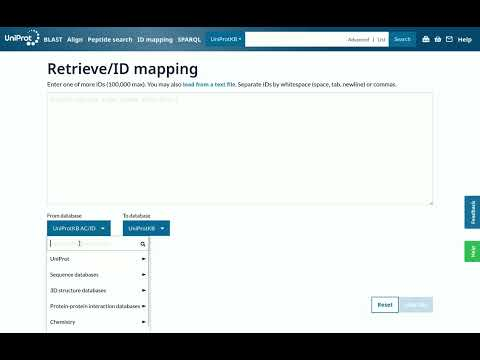

In [79]:
from IPython.display import YouTubeVideo
YouTubeVideo('djzUCJ90Nok')

Now, the `idmapping.tsv` file generated by this service can be read into a DataFrame.

In [80]:
MAPPING_DIRECTORY_NAME = "idmapping"
MAPPING_FILE_NAME = "idmapping.tsv"
MAPPING_FILE_PATH = os.path.join(DATA_DIRECTORY, MAPPING_DIRECTORY_NAME, MAPPING_FILE_NAME)

mapping_df = pd.read_csv(MAPPING_FILE_PATH, delimiter='\t')
mapping_df

,From,Entry,Protein names,Organism
0,6A94,P0ABE7,Soluble cytochrome b562 (Cytochrome b-562),Escherichia coli
1,6A94,P28223,5-hydroxytryptamine receptor 2A (5-HT-2) (5-HT...,Homo sapiens (Human)
2,5IU8,P0ABE7,Soluble cytochrome b562 (Cytochrome b-562),Escherichia coli
3,5IU8,P29274,Adenosine receptor A2a,Homo sapiens (Human)
4,6RZ6,P0ABE7,Soluble cytochrome b562 (Cytochrome b-562),Escherichia coli
...,...,...,...,...
46072,6RIE,P68314,DNA-directed RNA polymerase 7 kDa subunit (EC ...,Vaccinia virus (strain Ankara) (VACV)
46073,6RIE,Q76ZQ8,DNA-directed RNA polymerase 19 kDa subunit (EC...,Vaccinia virus (strain Ankara) (VACV)
46074,6RIE,Q76ZS0,DNA-directed RNA polymerase 18 kDa subunit (EC...,Vaccinia virus (strain Ankara) (VACV)
46075,3DDN,P9WNX3,D-3-phosphoglycerate dehydrogenase (PGDH) (EC ...,Mycobacterium tuberculosis (strain ATCC 25618 ...


In [81]:
mapping_df = mapping_df[mapping_df["Organism"] == "Homo sapiens (Human)"]
mapping_df = mapping_df.rename(columns={"From": "PDB ID", "Entry": "UniProtKB ID"})
mapping_df

,PDB ID,UniProtKB ID,Protein names,Organism
1,6A94,P28223,5-hydroxytryptamine receptor 2A (5-HT-2) (5-HT...,Homo sapiens (Human)
3,5IU8,P29274,Adenosine receptor A2a,Homo sapiens (Human)
6,3EML,P29274,Adenosine receptor A2a,Homo sapiens (Human)
7,2VN9,Q13557,Calcium/calmodulin-dependent protein kinase ty...,Homo sapiens (Human)
13,3U88,O00255,Menin,Homo sapiens (Human)
...,...,...,...,...
45979,3VS3,P08631,Tyrosine-protein kinase HCK (EC 2.7.10.2) (Hem...,Homo sapiens (Human)
45982,6ME6,P49286,Melatonin receptor type 1B (Mel-1B-R) (Mel1b r...,Homo sapiens (Human)
45989,3ODU,P61073,C-X-C chemokine receptor type 4 (CXC-R4) (CXCR...,Homo sapiens (Human)
45991,1LWW,O15527,N-glycosylase/DNA lyase [Includes: 8-oxoguanin...,Homo sapiens (Human)


In [82]:
mapped_df = tidy_df.merge(mapping_df, on="PDB ID")
mapped_df

,Unnamed: 0,Ligand ranking,Ligand Name,Site Ranking,Ligand Center Coordinate,Templates (PDBID_CHAIN_LIGANDRESIDUENUM_TMSCORE),Source,PDB ID,Chain,Ligand Residue Number,TM Score,_original_index,UniProtKB ID,Protein names,Organism
0,2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE,6V80,C,401,0.7710,2,A0A0B4J240,T cell receptor alpha variable 10,Homo sapiens (Human)
1,2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE,6V80,C,401,0.7710,2,P15813,Antigen-presenting glycoprotein CD1d (R3G1) (C...,Homo sapiens (Human)
2,2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE,6V80,C,401,0.7710,2,P61769,Beta-2-microglobulin [Cleaved into: Beta-2-mic...,Homo sapiens (Human)
3,3,4,QUX,4,"(22.886, 13.301, -12.264)",3TN0_C_303_0.7724,SEQUENCE,3TN0,C,303,0.7724,3,P01848,T cell receptor alpha chain constant,Homo sapiens (Human)
4,3,4,QUX,4,"(22.886, 13.301, -12.264)",3TN0_C_303_0.7724,SEQUENCE,3TN0,C,303,0.7724,3,P01850,T cell receptor beta constant 1,Homo sapiens (Human)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
731389,1126495,2,TAM,2,"(9.550, 14.342, -14.364)",6TMO_D_305_0.3325,SEQUENCE,6TMO,D,305,0.3325,1000861,P61769,Beta-2-microglobulin [Cleaved into: Beta-2-mic...,Homo sapiens (Human)
731390,1126495,2,TAM,2,"(9.550, 14.342, -14.364)",6TMO_D_305_0.3325,SEQUENCE,6TMO,D,305,0.3325,1000861,Q16655,Melanoma antigen recognized by T-cells 1 (MART...,Homo sapiens (Human)
731391,1126497,1,CAC,1,"(22.323, 11.302, -25.536)","5OYJ_C_610_0.4540, 1QG3_A_383_0.4128",STRUCTURE,5OYJ,C,610,0.4540,1000863,P35968,Vascular endothelial growth factor receptor 2 ...,Homo sapiens (Human)
731392,1126501,4,TRE,4,"(-17.024, -0.539, 6.014)",5OYJ_C_612_0.4540,STRUCTURE,5OYJ,C,612,0.4540,1000866,P35968,Vascular endothelial growth factor receptor 2 ...,Homo sapiens (Human)


### Adding the *embeddings*

In [83]:
import h5py

In [84]:
EMBEDDINGS_DIRECTORY_NAME = "prot5"
EMBEDDINGS_FILE_NAME = "per-protein.h5"
EMBEDDINGS_FILE_PATH = os.path.join(DATA_DIRECTORY, EMBEDDINGS_DIRECTORY_NAME, EMBEDDINGS_FILE_NAME)

h5_file = h5py.File(EMBEDDINGS_FILE_PATH, 'r')

In [85]:
embeddings_dict = {}

for k, v in h5_file.items():
    embeddings_dict[k] = v[:]

embeddings_df = pd.DataFrame(h5_file.keys(), columns=["UniProtKB ID"])
embeddings_df['Embedding'] = embeddings_df["UniProtKB ID"].apply(lambda x: embeddings_dict[x])
embeddings_df


,UniProtKB ID,Embedding
0,A0A024R1R8,"[0.0136, 0.03845, 0.03928, -0.0675, -0.02478, ..."
1,A0A024RBG1,"[0.05814, -0.00346, 0.01235, 0.00528, -0.00479..."
2,A0A024RCN7,"[0.0765, 0.09283, -0.01796, -0.03084, -0.11487..."
3,A0A075B6H5,"[-0.013695, 0.01872, 0.03156, -0.01376, -0.040..."
4,A0A075B6H7,"[-0.006634, 0.1047, 0.04846, -0.02766, -0.0466..."
...,...,...
20582,V9GZ13,"[0.01411, -0.03925, -0.0438, 0.00895, 0.02959,..."
20583,W5XKT8,"[-0.005398, -0.0164, 0.02481, 0.00849, -0.0183..."
20584,W6CW81,"[0.04953, -0.02298, 0.09766, 0.02063, -0.02242..."
20585,X6R8D5,"[0.01906, 0.02252, -0.0001704, 0.01918, -0.101..."


In [86]:
embedded_df = mapped_df.merge(embeddings_df, on="UniProtKB ID")
embedded_df


,Unnamed: 0,Ligand ranking,Ligand Name,Site Ranking,Ligand Center Coordinate,Templates (PDBID_CHAIN_LIGANDRESIDUENUM_TMSCORE),Source,PDB ID,Chain,Ligand Residue Number,TM Score,_original_index,UniProtKB ID,Protein names,Organism,Embedding
0,2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE,6V80,C,401,0.7710,2,A0A0B4J240,T cell receptor alpha variable 10,Homo sapiens (Human),"[-0.004986, 0.03047, 0.010735, 0.01293, -0.034..."
1,2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE,6V80,C,401,0.7710,2,P15813,Antigen-presenting glycoprotein CD1d (R3G1) (C...,Homo sapiens (Human),"[-0.04117, 0.0322, 0.03775, 0.00952, -0.01785,..."
2,2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE,6V80,C,401,0.7710,2,P61769,Beta-2-microglobulin [Cleaved into: Beta-2-mic...,Homo sapiens (Human),"[-0.01874, 0.04916, 0.00969, -0.02368, 0.00656..."
3,3,4,QUX,4,"(22.886, 13.301, -12.264)",3TN0_C_303_0.7724,SEQUENCE,3TN0,C,303,0.7724,3,P01848,T cell receptor alpha chain constant,Homo sapiens (Human),"[0.04257, -0.02495, 0.05762, 0.0624, 0.01094, ..."
4,3,4,QUX,4,"(22.886, 13.301, -12.264)",3TN0_C_303_0.7724,SEQUENCE,3TN0,C,303,0.7724,3,P01850,T cell receptor beta constant 1,Homo sapiens (Human),"[0.01142, 0.05823, 0.02934, 0.01851, 0.000608,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730489,1126495,2,TAM,2,"(9.550, 14.342, -14.364)",6TMO_D_305_0.3325,SEQUENCE,6TMO,D,305,0.3325,1000861,P61769,Beta-2-microglobulin [Cleaved into: Beta-2-mic...,Homo sapiens (Human),"[-0.01874, 0.04916, 0.00969, -0.02368, 0.00656..."
730490,1126495,2,TAM,2,"(9.550, 14.342, -14.364)",6TMO_D_305_0.3325,SEQUENCE,6TMO,D,305,0.3325,1000861,Q16655,Melanoma antigen recognized by T-cells 1 (MART...,Homo sapiens (Human),"[-0.004208, -0.02652, -0.0006356, 0.02728, -0...."
730491,1126497,1,CAC,1,"(22.323, 11.302, -25.536)","5OYJ_C_610_0.4540, 1QG3_A_383_0.4128",STRUCTURE,5OYJ,C,610,0.4540,1000863,P35968,Vascular endothelial growth factor receptor 2 ...,Homo sapiens (Human),"[0.03552, 0.01585, 0.03123, 0.02003, -0.01298,..."
730492,1126501,4,TRE,4,"(-17.024, -0.539, 6.014)",5OYJ_C_612_0.4540,STRUCTURE,5OYJ,C,612,0.4540,1000866,P35968,Vascular endothelial growth factor receptor 2 ...,Homo sapiens (Human),"[0.03552, 0.01585, 0.03123, 0.02003, -0.01298,..."


### Saving the final dataset

In [87]:
FINAL_FILE_NAME = "final.csv"
FINAL_FILE_PATH = os.path.join(DATA_DIRECTORY, FINAL_FILE_NAME)

final_df = embedded_df

if not os.path.exists(FINAL_FILE_PATH):
    final_df.to_csv(FINAL_FILE_PATH, index=False)

## Exploratory Analysis and Data Selection

### Alignment Quality (TM Score)

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Median = 0.7752


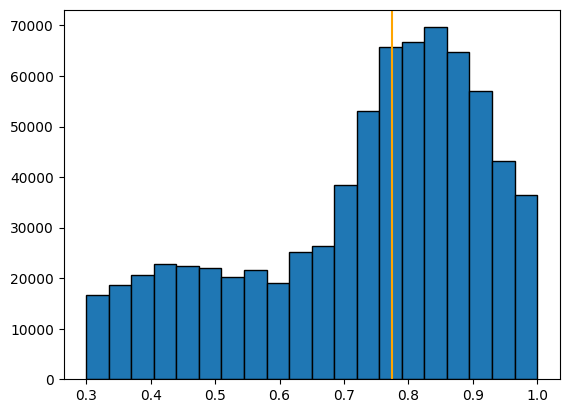

In [89]:
fig, ax = plt.subplots()
y = final_df['TM Score']

ax.hist(y, bins=20, edgecolor='black')

median = np.median(y)
print("Median =", median)
ax.axvline(x=median, color='orange', label='Median')

plt.show()

In [90]:
curated_df = final_df[final_df["TM Score"] >= 0.75]
curated_df

,Unnamed: 0,Ligand ranking,Ligand Name,Site Ranking,Ligand Center Coordinate,Templates (PDBID_CHAIN_LIGANDRESIDUENUM_TMSCORE),Source,PDB ID,Chain,Ligand Residue Number,TM Score,_original_index,UniProtKB ID,Protein names,Organism,Embedding
0,2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE,6V80,C,401,0.7710,2,A0A0B4J240,T cell receptor alpha variable 10,Homo sapiens (Human),"[-0.004986, 0.03047, 0.010735, 0.01293, -0.034..."
1,2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE,6V80,C,401,0.7710,2,P15813,Antigen-presenting glycoprotein CD1d (R3G1) (C...,Homo sapiens (Human),"[-0.04117, 0.0322, 0.03775, 0.00952, -0.01785,..."
2,2,3,AGH,3,"(23.210, 14.202, -10.878)",6V80_C_401_0.7710,SEQUENCE,6V80,C,401,0.7710,2,P61769,Beta-2-microglobulin [Cleaved into: Beta-2-mic...,Homo sapiens (Human),"[-0.01874, 0.04916, 0.00969, -0.02368, 0.00656..."
3,3,4,QUX,4,"(22.886, 13.301, -12.264)",3TN0_C_303_0.7724,SEQUENCE,3TN0,C,303,0.7724,3,P01848,T cell receptor alpha chain constant,Homo sapiens (Human),"[0.04257, -0.02495, 0.05762, 0.0624, 0.01094, ..."
4,3,4,QUX,4,"(22.886, 13.301, -12.264)",3TN0_C_303_0.7724,SEQUENCE,3TN0,C,303,0.7724,3,P01850,T cell receptor beta constant 1,Homo sapiens (Human),"[0.01142, 0.05823, 0.02934, 0.01851, 0.000608,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730480,1126479,35,URM,1,"(-1.763, 7.813, -8.405)",5C48_A_403_0.8514,STRUCTURE,5C48,A,403,0.8514,1000846,P16442,Histo-blood group ABO system transferase (Fuco...,Homo sapiens (Human),"[0.005173, 0.0378, 0.0666, 0.02321, -0.02026, ..."
730481,1126480,36,1GW,1,"(-2.120, 8.484, -8.756)",3IOI_A_355_0.8438,STRUCTURE,3IOI,A,355,0.8438,1000847,P16442,Histo-blood group ABO system transferase (Fuco...,Homo sapiens (Human),"[0.005173, 0.0378, 0.0666, 0.02321, -0.02026, ..."
730482,1126481,37,48C,1,"(-4.020, 9.199, -7.585)",4Y64_A_402_0.8668,STRUCTURE,4Y64,A,402,0.8668,1000848,P16442,Histo-blood group ABO system transferase (Fuco...,Homo sapiens (Human),"[0.005173, 0.0378, 0.0666, 0.02321, -0.02026, ..."
730483,1126482,38,48E,1,"(-1.297, 10.340, -8.770)",4Y62_A_402_0.8482,STRUCTURE,4Y62,A,402,0.8482,1000849,P16442,Histo-blood group ABO system transferase (Fuco...,Homo sapiens (Human),"[0.005173, 0.0378, 0.0666, 0.02321, -0.02026, ..."


### Number of Proteins per Ligand

In [91]:
import warnings

Ligand counts:         13445
Ligand counts (> 500): 45


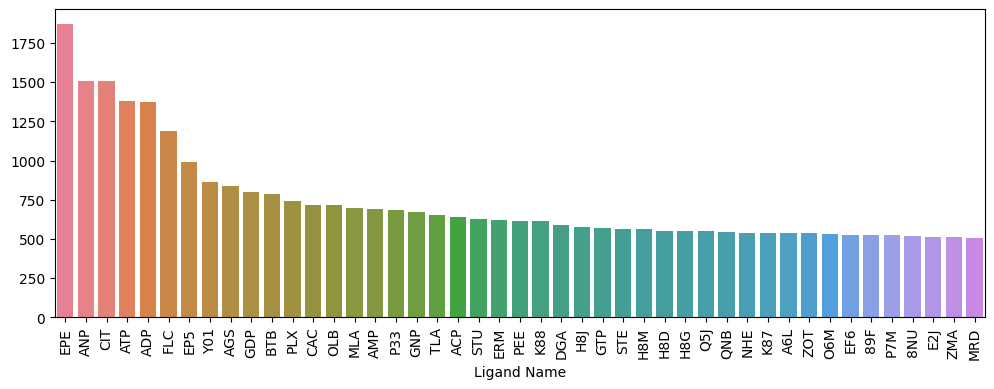

In [92]:
# Ignore seaborn warnings
warnings. filterwarnings('ignore')

cutoff = 500
ligand_counts = curated_df['Ligand Name'].value_counts()
ligand_counts_filtered = ligand_counts[ligand_counts > cutoff]

print("Ligand counts:        ", len(ligand_counts))
print(f"Ligand counts (> {cutoff}):", len(ligand_counts_filtered))

fig, ax = plt.subplots(figsize=(12,4))
y = ligand_counts_filtered
num_colors = len(ligand_counts_filtered) + 10
colors = sns.color_palette("husl", num_colors)
sns.barplot(x=y.index, y=y.values, hue=y.index, palette=colors)
plt.xticks(rotation=90)
plt.show()

Ligand counts (no outliers): 38


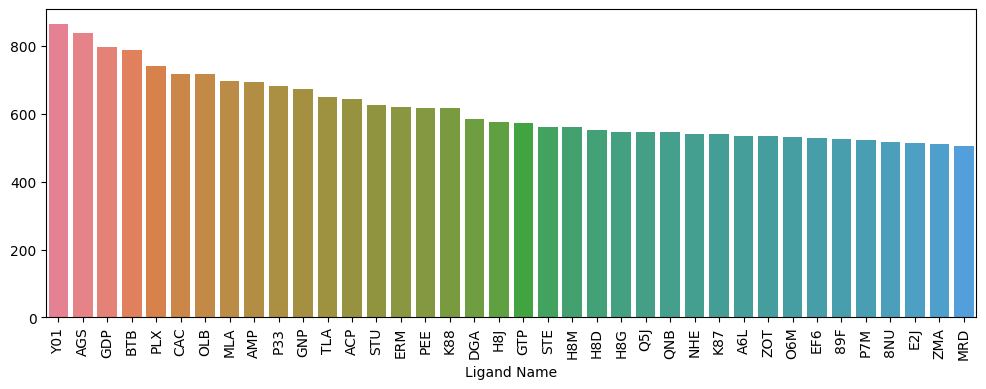

In [93]:
remove_greater_n = 7
ligand_counts_filtered_no_outliers = ligand_counts_filtered.tail(len(ligand_counts_filtered) - remove_greater_n)

print("Ligand counts (no outliers):", len(ligand_counts_filtered) - remove_greater_n)

fig, ax = plt.subplots(figsize=(12,4))
y = ligand_counts_filtered_no_outliers
num_colors = len(ligand_counts_filtered) + 10
colors = sns.color_palette("husl", num_colors)
sns.barplot(x=y.index, y=y.values, hue=y.index, palette=colors)
plt.xticks(rotation=90)
plt.show()

In [94]:
ligand_counts_filtered.to_frame()
subset_df = curated_df.merge(ligand_counts_filtered_no_outliers, on="Ligand Name")
subset_df

,Unnamed: 0,Ligand ranking,Ligand Name,Site Ranking,Ligand Center Coordinate,Templates (PDBID_CHAIN_LIGANDRESIDUENUM_TMSCORE),Source,PDB ID,Chain,Ligand Residue Number,TM Score,_original_index,UniProtKB ID,Protein names,Organism,Embedding,count
0,60,9,OLB,7,"(24.965, 1.217, -6.225)",5LWY_L_402_0.9185,STRUCTURE,5LWY,L,402,0.9185,60,Q86V24,Adiponectin receptor protein 2 (Progestin and ...,Homo sapiens (Human),"[0.05737, 0.0566, 0.03403, 0.0397, 0.0163, 0.0...",718
1,114,1,OLB,1,"(11.735, -11.289, -19.956)",5LWY_L_402_0.9665,STRUCTURE,5LWY,L,402,0.9665,114,Q86V24,Adiponectin receptor protein 2 (Progestin and ...,Homo sapiens (Human),"[0.05737, 0.0566, 0.03403, 0.0397, 0.0163, 0.0...",718
2,198,6,OLB,6,"(14.561, 8.349, -24.011)",5LWY_L_402_0.9139,STRUCTURE,5LWY,L,402,0.9139,197,Q86V24,Adiponectin receptor protein 2 (Progestin and ...,Homo sapiens (Human),"[0.05737, 0.0566, 0.03403, 0.0397, 0.0163, 0.0...",718
3,332,2,OLB,2,"(11.214, 14.053, -19.075)",5LWY_L_402_0.8471,STRUCTURE,5LWY,L,402,0.8471,329,Q86V24,Adiponectin receptor protein 2 (Progestin and ...,Homo sapiens (Human),"[0.05737, 0.0566, 0.03403, 0.0397, 0.0163, 0.0...",718
4,398,2,OLB,2,"(8.447, 5.214, -23.425)",5LWY_L_402_0.8280,STRUCTURE,5LWY,L,402,0.8280,394,Q86V24,Adiponectin receptor protein 2 (Progestin and ...,Homo sapiens (Human),"[0.05737, 0.0566, 0.03403, 0.0397, 0.0163, 0.0...",718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23341,1126168,56,ACP,1,"(4.069, 8.390, -4.800)",6RU6_A_301_0.7894,STRUCTURE,6RU6,A,301,0.7894,1000601,P48730,Casein kinase I isoform delta (CKI-delta) (CKI...,Homo sapiens (Human),"[0.0818, 0.1201, -0.00881, 0.01496, -0.01082, ...",643
23342,1126168,56,ACP,1,"(4.069, 8.390, -4.800)",6RU6_A_301_0.7894,STRUCTURE,6RU6,A,301,0.7894,1000601,Q9H3D4,Tumor protein 63 (p63) (Chronic ulcerative sto...,Homo sapiens (Human),"[0.04688, 0.04526, 0.0166, 0.05988, 0.00612, 0...",643
23343,1126309,1,CAC,1,"(4.681, 16.727, -4.023)",2J6E_H_1447_0.8928,SEQUENCE,2J6E,H,1447,0.8928,1000716,P01857,Immunoglobulin heavy constant gamma 1 (Ig gamm...,Homo sapiens (Human),"[0.00725, 0.08417, 0.046, 0.01036, -0.01434, -...",719
23344,1126332,1,CAC,1,"(0.229, -13.701, -6.046)",2J6E_H_1447_0.9052,SEQUENCE,2J6E,H,1447,0.9052,1000739,P01857,Immunoglobulin heavy constant gamma 1 (Ig gamm...,Homo sapiens (Human),"[0.00725, 0.08417, 0.046, 0.01036, -0.01434, -...",719


### Understanding the Ligands

To better understand the ligands, we can access their pages in the PDB. The code below generates the links to such pages.

In [95]:
ligands = subset_df["Ligand Name"].value_counts()

for ligand in ligands.index:
    print(f"{ligand}: https://www.rcsb.org/ligand/{ligand}")

Y01: https://www.rcsb.org/ligand/Y01
AGS: https://www.rcsb.org/ligand/AGS
GDP: https://www.rcsb.org/ligand/GDP
BTB: https://www.rcsb.org/ligand/BTB
PLX: https://www.rcsb.org/ligand/PLX
CAC: https://www.rcsb.org/ligand/CAC
OLB: https://www.rcsb.org/ligand/OLB
MLA: https://www.rcsb.org/ligand/MLA
AMP: https://www.rcsb.org/ligand/AMP
P33: https://www.rcsb.org/ligand/P33
GNP: https://www.rcsb.org/ligand/GNP
TLA: https://www.rcsb.org/ligand/TLA
ACP: https://www.rcsb.org/ligand/ACP
STU: https://www.rcsb.org/ligand/STU
ERM: https://www.rcsb.org/ligand/ERM
PEE: https://www.rcsb.org/ligand/PEE
K88: https://www.rcsb.org/ligand/K88
DGA: https://www.rcsb.org/ligand/DGA
H8J: https://www.rcsb.org/ligand/H8J
GTP: https://www.rcsb.org/ligand/GTP
STE: https://www.rcsb.org/ligand/STE
H8M: https://www.rcsb.org/ligand/H8M
H8D: https://www.rcsb.org/ligand/H8D
H8G: https://www.rcsb.org/ligand/H8G
Q5J: https://www.rcsb.org/ligand/Q5J
QNB: https://www.rcsb.org/ligand/QNB
NHE: https://www.rcsb.org/ligand/NHE
K

Among these ligangs, some interesting ones are:

|  Code  | Name | Application |
|--------|------|-------------|
| [TLA](https://www.rcsb.org/ligand/TLA) | *Tartaric acid* | Treatment of indigestion, heartburn, and kidney stones |
| [ERM](https://www.rcsb.org/ligand/ERM) | *Ergotamine* | Abortion or prevention of vascular headache |
| [H8D](https://www.rcsb.org/ligand/H8D) | *Metilergometrina* | Control of excessive bleeding following vaginal childbirth |
| [H8G](https://www.rcsb.org/ligand/H8G) | *Lisuride* | Parkinson's disease treatment |
| [ZOT](https://www.rcsb.org/ligand/ZOT) | *Zotepina* | Management of acute schizophrenic episodes |
| [8NU](https://www.rcsb.org/ligand/8NU) | *Risperidone* | Treatment of schizophrenia and bipolar disorder |
| [O6M](https://www.rcsb.org/ligand/O6M) | E-7820 | Investigated for the treatment of colon cancer and rectal cancer |
| [EF6](https://www.rcsb.org/ligand/EF6) | *Indisulam* | Investigated for the treatment of lung cancer |
| [P7M](https://www.rcsb.org/ligand/P7M) | *Tasisulam* | Investigated for the treatment of breast cancer and ovarian cancer |
| [E2J](https://www.rcsb.org/ligand/E2J) | *Ritanserin* | Investigated for the treatment of cocaine-related disorders |





## Classification

### Positional encoding

The binding site of a protein-ligand complex is, in this case, represented by the index of the amino acid of the protein that binds to the ligand. For example, if the 15<sup>th</sup> amino acid of a protein binds to a ligand, then the binding site is the number 15. This data is contemplated in the "Ligand Residue Number" column of the dataset.

To enrich our input vectors with binding site data, we have to somehow encode this integer as a vector with same dimensions as the ProT5 embeddings. We can then add those two vectors to get our final training vectors. For that, we will use a technique of frequency-based positional encoding. 

In [96]:
def position_embeddings(max_binding_position, d=1024, n=10000):
    P = np.zeros((max_binding_position, d))

    for k in range(max_binding_position):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
            
    return P

In [97]:
def generate_positional_encodings(max_binding_site) -> np.ndarray:
    pos_encodings=position_embeddings(max_binding_site)
    return pos_encodings

### Training

The function below will be used to train multiple models, using different subsets of the dataset (sequences only, structures only, and both).

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle

In [99]:
RESULTS_DIRECTORY_NAME: str = 'results'
MODELS_DIRECTORY_NAME: str = 'models'
REPORTS_DIRECTORY_NAME: str = 'reports'

MODELS_DIRECTORY_PATH: str = os.path.join(RESULTS_DIRECTORY_NAME, MODELS_DIRECTORY_NAME)
REPORTS_DIRECTORY_PATH: str = os.path.join(RESULTS_DIRECTORY_NAME, REPORTS_DIRECTORY_NAME)

In [105]:
def train(df: pd.DataFrame, description: str) -> None:

    # Apply positional encoding to the "Ligand Residue Number" column
    max_binding_site=max(df["Ligand Residue Number"])+1
    pos_encodings = generate_positional_encodings(max_binding_site)

    # Define input (X) and output (Y) of the model
    X_embedding = list(df["Embedding"])
    X_number = list(df["Ligand Residue Number"])
    X_number = list(map(lambda x: pos_encodings[x, :], X_number))
    X = [x+s for x,s in zip(X_embedding, X_number)]
    Y = list(df["Ligand Name"])

    # Partition the dataset
    x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.3, random_state=120, stratify=Y)

    # Train the logistic regression model
    model = LogisticRegression(penalty='l2', max_iter=300)
    model.fit(x_train, y_train)

    # Cross-validate results
    cv_scores = cross_val_score(model, x_train, y_train, cv=5, scoring='accuracy')
    print("Cross-validation scores:", cv_scores)
    print("Mean cross-validation score:", cv_scores.mean())

    # Save the model
    PICKLE_FILE_NAME = description + ".pkl"
    PICKLE_FILE_PATH = os.path.join(MODELS_DIRECTORY_PATH, PICKLE_FILE_NAME)
    with open(PICKLE_FILE_PATH,'wb') as f:
        pickle.dump(model,f)

    # Generate a performance report of the model
    report = classification_report(model.predict(x_test), y_test, output_dict=True)
    report_df = pd.DataFrame(report).transpose()
    print(report_df)


    # Save the performance report of the model
    REPORT_FILE_NAME = description + ".csv"
    REPORT_FILE_PATH = os.path.join(REPORTS_DIRECTORY_PATH, REPORT_FILE_NAME)
    report_df.to_csv(REPORT_FILE_PATH, index=True)

### Model I: Sequences

In [106]:
seq_df = subset_df[subset_df["Source"] == "SEQUENCE"]
train(df=seq_df, description="sequence")

Cross-validation scores: [0.9047619  0.90567766 0.91158956 0.90334402 0.90609253]
Mean cross-validation score: 0.9062931342592359
              precision    recall  f1-score     support
89F            1.000000  0.993711  0.996845   159.00000
8NU            0.000000  0.000000  0.000000     0.00000
A6L            1.000000  1.000000  1.000000   161.00000
ACP            0.875000  0.958904  0.915033    73.00000
AGS            0.926667  0.945578  0.936027   147.00000
AMP            0.886792  0.969072  0.926108    97.00000
BTB            0.947917  0.968085  0.957895    94.00000
CAC            0.991935  0.953488  0.972332   129.00000
DGA            1.000000  1.000000  1.000000   175.00000
E2J            1.000000  0.962500  0.980892   160.00000
ERM            0.365591  1.000000  0.535433    68.00000
GDP            0.864000  0.800000  0.830769   135.00000
GNP            0.871287  0.792793  0.830189   111.00000
GTP            0.640449  0.876923  0.740260    65.00000
H8D            1.000000  0.988

### Model II: Structures

In [107]:
str_df = subset_df[subset_df["Source"] == "STRUCTURE"]
train(df=str_df, description="structure")

Cross-validation scores: [0.93087558 0.94193548 0.91059908 0.93364055 0.93450185]
Mean cross-validation score: 0.9303105072525379
              precision    recall  f1-score      support
ACP            0.902655  1.000000  0.948837   102.000000
AGS            0.930693  0.895238  0.912621   105.000000
AMP            0.883495  0.928571  0.905473    98.000000
BTB            0.992857  0.992857  0.992857   140.000000
CAC            0.978261  0.947368  0.962567    95.000000
DGA            0.000000  0.000000  0.000000     0.000000
EF6            0.981013  0.993590  0.987261   156.000000
GDP            0.912281  0.825397  0.866667   126.000000
GNP            0.871287  0.916667  0.893401    96.000000
GTP            0.710843  0.867647  0.781457    68.000000
K88            1.000000  1.000000  1.000000    82.000000
MLA            0.956204  0.977612  0.966790   134.000000
MRD            0.936842  1.000000  0.967391    89.000000
NHE            0.844444  0.950000  0.894118    40.000000
O6M            

### Model III: Sequences + Structures

In [108]:
both_df = subset_df
train(df=both_df, description="both")

Cross-validation scores: [0.92688896 0.9223004  0.92656059 0.92594859 0.92962056]
Mean cross-validation score: 0.926263819500946
              precision    recall  f1-score      support
89F            1.000000  0.975309  0.987500   162.000000
8NU            0.000000  0.000000  0.000000     0.000000
A6L            1.000000  1.000000  1.000000   161.000000
ACP            0.943005  0.978495  0.960422   186.000000
AGS            0.968127  0.952941  0.960474   255.000000
AMP            0.937500  0.919811  0.928571   212.000000
BTB            0.978903  0.995708  0.987234   233.000000
CAC            1.000000  0.981818  0.990826   220.000000
DGA            0.994318  0.988701  0.991501   177.000000
E2J            1.000000  0.980892  0.990354   157.000000
EF6            0.993671  1.000000  0.996825   157.000000
ERM            0.403226  1.000000  0.574713    75.000000
GDP            0.878661  0.853659  0.865979   246.000000
GNP            0.866337  0.883838  0.875000   198.000000
GTP            0

## Results and Conclusion

All three models performed excellently, with average accuracy above 90%. The most interesting result was that model I (which was trained only with sequence data) performed very close to models II and III (which were trained using structure data). This is excellent news, since computing protein structures is a computationally expensive task, so it was interesting to demonstrate that it is possible to obtain a high-performance model without such structure data.

## References

1. UniProtKB/Swiss-Prot. Expasy.org. Published 2019. https://web.expasy.org/docs/swiss-prot_guideline.html

2. Elnaggar A, Heinzinger M, Dallago C, et al. ProtTrans: Towards Cracking the Language of Lifes Code Through Self-Supervised Deep Learning and High Performance Computing. IEEE Transactions on Pattern Analysis and Machine Intelligence. Published online 2021:1-1. doi:https://doi.org/10.1109/tpami.2021.3095381

3. Sarker B, Shome S, Rahman F, Aghaeepour N. Tutorial VT2: Protein Sequence Analysis using Transformer-based Large Language Model. Published July 2023. Accessed June 4, 2024. https://github.com/Bishnukuet/ISMB_ECCB_2023_Tutorial-VT2-LLM-For-Protein-Sequence-Analysis

4. Saeed M. A Gentle Introduction to Positional Encoding In Transformer Models, Part 1. Machine Learning Mastery. Published January 31, 2022. https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/

5. Sim J, Kwon S, Seok C. HProteome-BSite: predicted binding sites and ligands in human 3D proteome. Nucleic acids research. 2022;51(D1):D403-D408. doi:https://doi.org/10.1093/nar/gkac873

6. Heo L, Shin WH, Lee MS, Seok C. GalaxySite: ligand-binding-site prediction by using molecular docking. Nucleic Acids Research. 2014;42(W1):W210-W214. doi:https://doi.org/10.1093/nar/gku321

7. Sage Bionetworks. CAFA - UniProt Metal Binding Challenge. www.synapse.org. Accessed June 4, 2024. https://www.synapse.org/Synapse:syn50209128/wiki/6202598.Residue (chemistry). Wikipedia. Published November 16, 2022. https://en.wikipedia.org/wiki/Residue_(chemistry)

9. Druglikeness. Wikipedia. Published November 23, 2023. https://en.wikipedia.org/wiki/Druglikeness

10. PDB101: Learn: Guide to Understanding PDB Data: Small Molecule Ligands. RCSB: PDB-101. Accessed June 5, 2024. https://pdb101.rcsb.org/learn/guide-to-understanding-pdb-data/small-molecule-ligands

11. Wang R, Fang X, Lu Y, Wang S. The PDBbind Database:  Collection of Binding Affinities for Protein−Ligand Complexes with Known Three-Dimensional Structures. Journal of Medicinal Chemistry. 2004;47(12):2977-2980. doi:https://doi.org/10.1021/jm030580l

12. Qu X, Swanson R, Day R, Tsai J. A Guide to Template Based Structure Prediction. Current Protein & Peptide Science. 2009;10(3):270-285. doi:https://doi.org/10.2174/138920309788452182

13. Fiser A. Template-Based Protein Structure Modeling. Methods in Molecular Biology. Published online 2010:73-94. doi:https://doi.org/10.1007/978-1-60761-842-3_6